# TURNSTILE DATA ANALYSIS

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)


## Import Data Frame to Summarize Turnstile Entries & Exits
#### 1) Data Acquisition

- Collect all turnstile data for **March to end May** for last **4 years (2016 to 2019)**.
- Annual Gala is held at the beginning of each summer, therefore the subway campaign would take place in the 3 months leading up to June
- For this reason, only March to May Turnstile data is collected, in order to focus on determining annual foot traffic trends within this time period

#### 2) Load Data from Pickle:

In [2]:
# Read pickled datafile
turnstile_df = pd.read_pickle('data.pkl')

In [3]:
# Modify data types for numeric and date fields
turnstile_df['ENTRIES'] = turnstile_df['ENTRIES'].astype(np.int)
turnstile_df['EXITS'] = turnstile_df['EXITS'].astype(np.int)

In [4]:
turnstile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10303675 entries, 0 to 10303674
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 864.7+ MB


In [5]:
turnstile_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

#### 2) Modify Data Frame to Prepare for Analysis:

In [6]:
# Create Pandas series with dates and times
date = pd.to_datetime(turnstile_df['DATE'], format='%m/%d/%Y')
time = pd.to_datetime(turnstile_df['TIME'], format='%H:%M:%S')

# Create distinct columns to define year, month, day of week, hour and minute of turnstile data
turnstile_df['year'] = date.dt.year
turnstile_df['month'] = date.dt.month
turnstile_df['day'] = date.dt.day
turnstile_df['day_of_week'] = date.dt.weekday
turnstile_df['hour'] = time.dt.hour
turnstile_df['minute'] = time.dt.minute

In [7]:
# Create concatenated field for Turnstile Key (UNIT + SCP)
turnstile_df.insert(0, 'TURNSTILE', turnstile_df['UNIT']+'|'+turnstile_df['SCP'])

In [8]:
# Create field to flag weekday or weekend transactions
turnstile_df.loc[turnstile_df['day_of_week'] < 5, 'WD vs WE'] = 'WD'
turnstile_df.loc[turnstile_df['day_of_week'] > 4, 'WD vs WE'] = 'WE'

In [9]:
turnstile_df.head(10)

,TURNSTILE,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day,day_of_week,hour,minute,WD vs WE
0,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019,3,23,5,0,0,WE
1,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019,3,23,5,4,0,WE
2,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019,3,23,5,8,0,WE
3,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019,3,23,5,12,0,WE
4,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019,3,23,5,16,0,WE
5,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,20:00:00,REGULAR,6990562,2370623,2019,3,23,5,20,0,WE
6,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2019,00:00:00,REGULAR,6990734,2370648,2019,3,24,6,0,0,WE
7,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2019,04:00:00,REGULAR,6990758,2370653,2019,3,24,6,4,0,WE
8,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2019,08:00:00,REGULAR,6990772,2370676,2019,3,24,6,8,0,WE
9,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2019,12:00:00,REGULAR,6990860,2370731,2019,3,24,6,12,0,WE


## Calculate number of entries in each time period (`entries_delta`)

- Group DataFrame by turnstile and sort by date
- Define an appropriate time period
- Check for inconsistent data

In order to identify unique turnstiles, we use two key definitions from the [MTA transit toolkit](http://transitdatatoolkit.com/lessons/subway-turnstile-data/):

- `UNIT`: The remote unit is a collection of turnstiles... there can be multiple remote units one station
- `SCP`: Subunit channel position represents a turnstile... the same number can be used at different stations

Together, `UNIT` and `SCP` make a unique identifier for NYC turnstiles. 

#### 1) Create Data Frame with Computed `ENTRIES` & `EXITS` per `TURNSTILE` per `DATE` & `hour`

In [10]:
# Create dataframe that consolidates each Turnstile (Unit + SCP); take the max entries & exits
# This will be used to determine the difference between Entries & Exits for each day
cons_turnstile_df = turnstile_df    \
                        .groupby(['TURNSTILE', 'STATION','year','month','day','hour', 'WD vs WE'])    \
                        .agg({'ENTRIES':'max', 'EXITS':'max'}).reset_index()

In [11]:
cons_turnstile_df.sort_values(['TURNSTILE', 'STATION', 'year', 'month','day','hour', 'WD vs WE'], inplace=True)

In [12]:
cons_turnstile_df.head(10)

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179
1,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,4,WE,1699131,1615186
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404
6,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,0,WE,1699792,1615423
7,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,4,WE,1699799,1615426
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472


In [13]:
# Compute the delta of total Entries between each consecutive row (turnstile, date and hour grouping).
# Combination of "groupby", "apply" and "rolling" allow computations to occur over a window of two rows
# and compute only within the group of 'Turnstile' and 'Year' to avoid drastic changes in the delta counter
cons_turnstile_df['Entries Delta'] = cons_turnstile_df.groupby(['TURNSTILE', 'year'])['ENTRIES']    \
                        .apply(lambda x: x.rolling(2)    \
                        .apply(lambda x: x[1] - x[0] if ((x[1] - x[0]) >= 0) and    \
                               ((x[1] - x[0]) <= 4800) else np.nan, raw=True))

In [14]:
# Compute the delta of total Exits between each consecutive row (turnstile, date and hour grouping).
# Combination of "groupby", "apply" and "rolling" allow computations to occur over a window of two rows
# and compute only within the group of 'Turnstile' and 'Year' to avoid drastic changes in the delta counter
cons_turnstile_df['Exits Delta'] = cons_turnstile_df.groupby(['TURNSTILE', 'year'])['EXITS']    \
                        .apply(lambda x: x.rolling(2)    \
                        .apply(lambda x: x[1] - x[0] if ((x[1] - x[0]) >= 0) and    \
                               ((x[1] - x[0]) <= 4800) else np.nan, raw=True))

In [15]:
# Create column that computes total Entries & Exits (total foot traffic)
cons_turnstile_df['Cum. Entries & Exits'] = cons_turnstile_df['Entries Delta'] + cons_turnstile_df['Exits Delta']

In [16]:
cons_turnstile_df.head(10)

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179,NaN,NaN,NaN
1,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,4,WE,1699131,1615186,12.0,7.0,19.0
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191,23.0,5.0,28.0
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253,140.0,62.0,202.0
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328,222.0,75.0,297.0
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404,230.0,76.0,306.0
6,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,0,WE,1699792,1615423,46.0,19.0,65.0
7,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,4,WE,1699799,1615426,7.0,3.0,10.0
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432,18.0,6.0,24.0
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472,70.0,40.0,110.0


In [17]:
# Create Key in cons_turnstile_df for TURNSTILE + hour
# To be used for determining Mean "Cum. Entries & Exits" for each Turnstile at different times of the day
cons_turnstile_df['TURNSTILE'] = cons_turnstile_df['TURNSTILE'].astype(str)
cons_turnstile_df['hour'] = cons_turnstile_df['hour'].astype(str)
cons_turnstile_df['turnstile_hour_key'] = cons_turnstile_df['TURNSTILE'] + '|' + cons_turnstile_df['hour']
cons_turnstile_df.head(10)

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0
1,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,4,WE,1699131,1615186,12.0,7.0,19.0,R001|00-00-00|4
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404,230.0,76.0,306.0,R001|00-00-00|20
6,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,0,WE,1699792,1615423,46.0,19.0,65.0,R001|00-00-00|0
7,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,4,WE,1699799,1615426,7.0,3.0,10.0,R001|00-00-00|4
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432,18.0,6.0,24.0,R001|00-00-00|8
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12


****
##### NOTE:
>`cons_turnstile_df` to be used further down for merging with `avg_volume_df`
****

#### 2)  CALCULATE THE AVERAGE VOLUME (by Turnstile for each hour timeslot)
> To be used to populate all cases of NaN for `Cum. Entries & Exits`

In [18]:
# Create staging table that will be used for calculating Avg. Entries & Exits field
avg_vol_df_staging = cons_turnstile_df.groupby(['TURNSTILE', 'STATION', 'WD vs WE', 'hour'])    \
                                       .agg({'Cum. Entries & Exits':'sum'}).reset_index()

In [19]:
# NaN values removed through Sum function - to be used for calculating average
avg_vol_df_staging['Cum. Entries & Exits'].isnull().sum()

0

In [20]:
# Create average_volume_df to contain average total entries & exits for each Turnstile for every hour timeslot
# Create Key in cons_turnstile_df3 for TURNSTILE + hour
average_volume_df = avg_vol_df_staging.groupby(['TURNSTILE', 'hour'])    \
                                      .agg({'Cum. Entries & Exits':'mean'}).reset_index()
average_volume_df.rename(columns={'Cum. Entries & Exits': 'Mean Entries & Exits'}, inplace=True)
average_volume_df['TURNSTILE'] = average_volume_df['TURNSTILE'].astype(str)
average_volume_df['hour'] = average_volume_df['hour'].astype(str)
average_volume_df['turnstile_hour_key'] = average_volume_df['TURNSTILE'] + '|' + average_volume_df['hour']
average_volume_df.drop(columns=['TURNSTILE', 'hour'], inplace=True)
average_volume_df

,Mean Entries & Exits,turnstile_hour_key
0,7179.0,R001|00-00-00|0
1,30921.5,R001|00-00-00|1
2,174.0,R001|00-00-00|10
3,156.0,R001|00-00-00|11
4,18602.5,R001|00-00-00|12
5,87005.0,R001|00-00-00|13
6,16859.5,R001|00-00-00|16
7,108286.0,R001|00-00-00|17
8,620.0,R001|00-00-00|18
9,26.0,R001|00-00-00|19


## CREATE FINAL WORKING DATA FRAME:

#### 1) Merge `cons_turnstile_df` dataframe with `average_volume_df`

In [21]:
cons_turnstile_df2 = pd.merge(cons_turnstile_df, average_volume_df, on='turnstile_hour_key', how='left')
cons_turnstile_df2

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0,7179.0
1,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,4,WE,1699131,1615186,12.0,7.0,19.0,R001|00-00-00|4,1766.5
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8,11694.5
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12,18602.5
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16,16859.5
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404,230.0,76.0,306.0,R001|00-00-00|20,22781.5
6,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,0,WE,1699792,1615423,46.0,19.0,65.0,R001|00-00-00|0,7179.0
7,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,4,WE,1699799,1615426,7.0,3.0,10.0,R001|00-00-00|4,1766.5
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432,18.0,6.0,24.0,R001|00-00-00|8,11694.5
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12,18602.5


In [22]:
# Identify all rows with NaN for 'Cum. Entries & Exits'
cons_turnstile_df2[np.isnan(cons_turnstile_df2['Cum. Entries & Exits'])]

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0,7179.0
551,R001|00-00-00,WHITEHALL S-FRY,2017,2,25,0,WE,2243265,1838586,NaN,NaN,NaN,R001|00-00-00|0,7179.0
1102,R001|00-00-00,WHITEHALL S-FRY,2018,2,24,0,WE,3097287,2197711,NaN,NaN,NaN,R001|00-00-00|0,7179.0
1647,R001|00-00-00,WHITEHALL S-FRY,2019,2,23,0,WE,4104196,2551855,NaN,NaN,NaN,R001|00-00-00|0,7179.0
2199,R001|00-00-01,WHITEHALL S-FRY,2016,2,27,0,WE,1411875,1122986,NaN,NaN,NaN,R001|00-00-01|0,6934.0
2751,R001|00-00-01,WHITEHALL S-FRY,2017,2,25,0,WE,1873943,1370803,NaN,NaN,NaN,R001|00-00-01|0,6934.0
3303,R001|00-00-01,WHITEHALL S-FRY,2018,2,24,0,WE,2568734,1749953,NaN,NaN,NaN,R001|00-00-01|0,6934.0
3848,R001|00-00-01,WHITEHALL S-FRY,2019,2,23,0,WE,3320946,2137303,NaN,NaN,NaN,R001|00-00-01|0,6934.0
4401,R001|00-00-02,WHITEHALL S-FRY,2016,2,27,0,WE,467954,416107,NaN,NaN,NaN,R001|00-00-02|0,6528.0
4953,R001|00-00-02,WHITEHALL S-FRY,2017,2,25,0,WE,873995,728968,NaN,NaN,NaN,R001|00-00-02|0,6528.0


#### 2) Replace all NaN Values in "Cum. Entries & Exits" with values from 'Mean Entries & Exits'

In [41]:
# Create copy of cons_turnstile_df2 in order to apply replacement of NaN values without changing original df in place
cons_turnstile_df3 = cons_turnstile_df2.copy()

In [42]:
# Replace all records with NaN in the 'Cum. Entries & Exits' field with valye from 'Mean Entries & Exits'
cons_turnstile_df3.loc[np.isnan(cons_turnstile_df3['Cum. Entries & Exits']),'Cum. Entries & Exits'] = cons_turnstile_df3['Mean Entries & Exits'][np.isnan(cons_turnstile_df3['Cum. Entries & Exits'])]

In [43]:
# Convert 'hour' field back to type int
cons_turnstile_df3['hour'] = cons_turnstile_df3['hour'].astype(int)

In [44]:
cons_turnstile_df3

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,0,WE,1699119,1615179,NaN,NaN,7179.0,R001|00-00-00|0,7179.0
1,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,4,WE,1699131,1615186,12.0,7.0,19.0,R001|00-00-00|4,1766.5
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8,11694.5
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12,18602.5
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16,16859.5
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404,230.0,76.0,306.0,R001|00-00-00|20,22781.5
6,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,0,WE,1699792,1615423,46.0,19.0,65.0,R001|00-00-00|0,7179.0
7,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,4,WE,1699799,1615426,7.0,3.0,10.0,R001|00-00-00|4,1766.5
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432,18.0,6.0,24.0,R001|00-00-00|8,11694.5
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12,18602.5


In [45]:
# Review all time slots in data ('hour')
cons_turnstile_df3['hour'].unique()

array([ 0,  4,  8, 12, 16, 20,  5,  9, 13, 17, 21,  1,  7, 10, 11, 18, 19,
       14,  3, 15, 23,  6, 22,  2])

#### 3) Create new DataFrame to remove rows with timestamp below 8am and above 8pm

In [46]:
cons_turnstile_df4 = cons_turnstile_df3[(cons_turnstile_df3['hour'] >= 8) & (cons_turnstile_df3['hour'] <= 23)]
cons_turnstile_df4['hour'].unique()

array([ 8, 12, 16, 20,  9, 13, 17, 21, 10, 11, 18, 19, 14, 15, 23, 22])

In [47]:
cons_turnstile_df4

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8,11694.5
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12,18602.5
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16,16859.5
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,1699746,1615404,230.0,76.0,306.0,R001|00-00-00|20,22781.5
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,1699817,1615432,18.0,6.0,24.0,R001|00-00-00|8,11694.5
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12,18602.5
10,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,16,WE,1700070,1615557,183.0,85.0,268.0,R001|00-00-00|16,16859.5
11,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,20,WE,1700253,1615607,183.0,50.0,233.0,R001|00-00-00|20,22781.5
14,R001|00-00-00,WHITEHALL S-FRY,2016,2,29,8,WD,1700386,1615652,99.0,25.0,124.0,R001|00-00-00|8,11694.5
15,R001|00-00-00,WHITEHALL S-FRY,2016,2,29,12,WD,1700602,1615748,216.0,96.0,312.0,R001|00-00-00|12,18602.5


In [48]:
# Drop unecessary fields
cons_turnstile_df4.drop(columns=['ENTRIES', 'EXITS', 'Entries Delta', 'Exits Delta', 'turnstile_hour_key'], inplace=True)

In [50]:
cons_turnstile_df4

,TURNSTILE,STATION,year,month,day,hour,WD vs WE,Cum. Entries & Exits,Mean Entries & Exits
2,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,8,WE,28.0,11694.5
3,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,12,WE,202.0,18602.5
4,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,16,WE,297.0,16859.5
5,R001|00-00-00,WHITEHALL S-FRY,2016,2,27,20,WE,306.0,22781.5
8,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,8,WE,24.0,11694.5
9,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,12,WE,110.0,18602.5
10,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,16,WE,268.0,16859.5
11,R001|00-00-00,WHITEHALL S-FRY,2016,2,28,20,WE,233.0,22781.5
14,R001|00-00-00,WHITEHALL S-FRY,2016,2,29,8,WD,124.0,11694.5
15,R001|00-00-00,WHITEHALL S-FRY,2016,2,29,12,WD,312.0,18602.5


In [51]:
cons_turnstile_df4.to_pickle('data_clean.pkl')

## PLOTTING DATA:

#### 1) Plot total entries & Exits by Station:

In [51]:
stations_total = cons_turnstile_df4.groupby('STATION').agg({'Cum. Entries & Exits':'sum'})
stations_total['Cum. Entries & Exits'] = stations_total['Cum. Entries & Exits']/1000
stations_total_top10 = stations_total.nlargest(10, 'Cum. Entries & Exits').reset_index()
stations_total_top10

,STATION,Cum. Entries & Exits
0,34 ST-PENN STA,89248.832
1,GRD CNTRL-42 ST,80221.253
2,34 ST-HERALD SQ,63556.227
3,23 ST,57056.324
4,14 ST-UNION SQ,56804.212
5,TIMES SQ-42 ST,51213.673
6,FULTON ST,48407.103
7,86 ST,48384.015
8,42 ST-PORT AUTH,45858.295
9,125 ST,38891.212


In [60]:
stations_total_top10['STATION'].values

array(['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST',
       '14 ST-UNION SQ', 'TIMES SQ-42 ST', 'FULTON ST', '86 ST',
       '42 ST-PORT AUTH', '125 ST'], dtype=object)

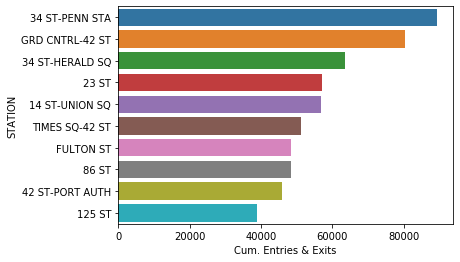

In [52]:
#stations_total_top10.plot(kind='bar', x='Cum. Entries & Exits', y='STATION')
sns.barplot(x='Cum. Entries & Exits', y='STATION', data=stations_total_top10)


#### 2) Plot Day of Week against Time of day:

In [59]:
day_comp_total = cons_turnstile_df4.groupby(['WD vs WE', 'hour']).agg({'Cum. Entries & Exits':'sum'})
day_comp_total['Cum. Entries & Exits'] = day_comp_total['Cum. Entries & Exits']/1000000
day_comp_total = day_comp_total.reset_index()
day_comp_total.head(32)

,WD vs WE,hour,Cum. Entries & Exits
0,WD,8,185.736
1,WD,9,186.978
2,WD,10,34.737
3,WD,11,83.831
4,WD,12,368.978
5,WD,13,159.802
6,WD,14,16.149
7,WD,15,44.838
8,WD,16,283.784
9,WD,17,194.227


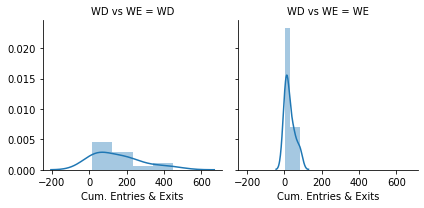

In [54]:
g = sns.FacetGrid(day_comp_total, col='WD vs WE', sharex=True, sharey=True)
g.map(sns.distplot, 'Cum. Entries & Exits',norm_hist=False);

>From the above graphs we can see there is little variability in total entries/exits on the weekends based on the time of the day. In general there is very little volume on the weekends.

>We can also see that there is a large variability in total entries/exits based on the time of day. Let's take a look below to determine what times of day dictate the highest traffic.

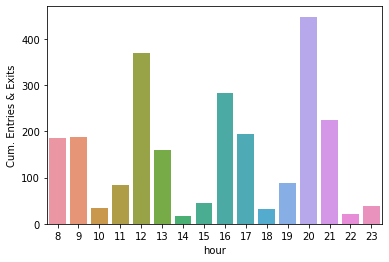

In [55]:
sns.barplot(x='hour', y='Cum. Entries & Exits', data=day_comp_total[day_comp_total['WD vs WE'] == 'WD'])

In [70]:
station_hour_total = cons_turnstile_df4.groupby(['STATION','year', 'hour']).agg({'Cum. Entries & Exits':'sum'})
station_hour_total['Cum. Entries & Exits'] = station_hour_total['Cum. Entries & Exits']/1000
station_hour_total = station_hour_total.reset_index()
station_hour_total = station_hour_total.loc[station_hour_total['STATION']    \
                                       .isin(stations_total_top10['STATION'].values)]

station_hour_total['STATION'].unique()

array(['125 ST', '14 ST-UNION SQ', '23 ST', '34 ST-HERALD SQ',
       '34 ST-PENN STA', '42 ST-PORT AUTH', '86 ST', 'FULTON ST',
       'GRD CNTRL-42 ST', 'TIMES SQ-42 ST'], dtype=object)

In [73]:
sorted(list(cons_turnstile_df4['STATION'].unique()))

['1 AV',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST CITY COL',
 '138/GRAND CONC',
 '14 ST',
 '14 ST-UNION SQ',
 '145 ST',
 '149/GRAND CONC',
 '14TH STREET',
 '15 ST-PROSPECT',
 '155 ST',
 '157 ST',
 '161/YANKEE STAD',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 STS',
 '175 ST',
 '176 ST',
 '18 AV',
 '18 ST',
 '181 ST',
 '182-183 STS',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AV',
 '20 AV',
 '207 ST',
 '21 ST',
 '21 ST-QNSBRIDGE',
 '215 ST',
 '219 ST',
 '225 ST',
 '23 ST',
 '231 ST',
 '233 ST',
 '238 ST',
 '25 AV',
 '25 ST',
 '28 ST',
 '3 AV',
 '3 AV 138 ST',
 '3 AV-149 ST',
 '30 AV',
 '33 ST',
 '33 ST-RAWSON ST',
 '34 ST-HERALD SQ',
 '34 ST-HUDSON YD',
 '34 ST-PENN STA',
 '36 AV',
 '36 ST',
 '39 AV',
 '4 AV-9 ST',
 '40 ST LOWERY ST',
 '42 ST-BRYANT PK',
 '42 ST-PORT AUTH',
 '45 ST',
 '46 ST',
 '46 ST BLISS ST',
 '47-50 STS ROCK',
 '49 ST',
 '4AV-9 ST',
 '5 AV